In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['genome_tags.csv', 'tag.csv', 'rating.csv', 'genome_scores.csv', 'movie.csv', 'link.csv']


# Data Exploration

In [2]:
# Note: This doesn't actually correlate the movieIds to the actual movies in this csv
df_rating = pd.read_csv('../input/rating.csv')
df_rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [3]:
df_rating.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [4]:
df_rating['rating'].describe()

count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [5]:
df_rating['rating'].min(), df_rating['rating'].max()

(0.5, 5.0)

In [6]:
#TODO This is wrong for some reason. len(df_rating['movieId'].unique()) gives the actual answer?

print("Number of unique users", "{:,}".format(df_rating['userId'].unique().sum()))
print("Number of unique movies", "{:,}".format(df_rating['movieId'].unique().sum()))

Number of unique users 9,590,224,771
Number of unique movies 1,572,269,395


In [7]:
df_movie = pd.read_csv('../input/movie.csv')
df_movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
df_movie['title'][0]

'Toy Story (1995)'

In [10]:
# TODO graph of movies per year
# TODO graph of ratings per year
# TODO graph of number of ratings per year
# TODO graph of avg rating per year

# df_movie['year'] = np.nan
# df_movie.head()

# BROKEN TODO
# This should create a new column called year for years extracted from all the movies
# import re
# for i in range(0, len(df_movie['title'])):
#     try:
#         df_movie['year'][i] = re.search('(\d{4})', df_movie['title'][i]).group(1)
#     except AttributeError:
#         df_movie['year'][i] = np.nan
# #     found = re.search('(\d{4})', year).group(1)
# #     if found:
# #         df_movie['year'] = found
# #     else:
# #         df_movie['year'] = np.nan
# df_movie.head()

In [11]:
df_movie.isna().sum()

movieId        0
title          0
genres         0
year       27278
dtype: int64

In [12]:
# for genre in genres
# split by |
# create a new genre column (ie genre1, genre2, etc.)
# TODO

# for genres in df_movie['genres']:
#     genres.split('|')

In [19]:
df_combined = pd.merge(df_movie,df_rating)
df_combined.head()

,movieId,title,genres,year,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,3,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,6,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,8,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,10,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,11,4.5,2009-01-02 01:13:41


# Neural Network Modeling

In [15]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_rating, test_size = .2)

len(train), len(test)

(16000210, 4000053)

In [38]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.models import Model
from keras.utils.vis_utils import model_to_dot

In [39]:
df_combined.head()

,movieId,title,genres,year,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,3,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,6,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,8,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,10,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,11,4.5,2009-01-02 01:13:41


In [52]:
n_latent_factors = 3
num_movies = len(df_combined['movieId'].unique())
movie_input = keras.layers.Input(shape = [1], name = 'Item')
movie_embed = keras.layers.Embedding(num_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name = "FlattenMovies")(movie_embed)

num_users = len(df_combined['userId'].unique())
user_input = keras.layers.Input(shape = [1],name='User')
user_vec = keras.layers.Flatten(name = "FlattenUsers")(keras.layers.Embedding(num_users + 1, n_latent_factors,name='User-Embedding')(user_input))

# dot_prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
dot_prod = keras.layers.concatenate([movie_vec, user_vec])
model = keras.Model([movie_input, user_input], dot_prod)
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

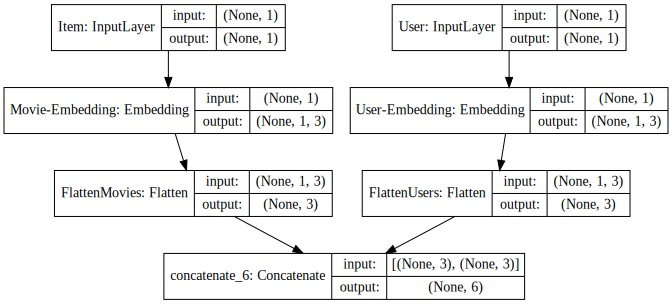

In [53]:
SVG(model_to_dot(model, show_shapes = True, show_layer_names = True, rankdir = 'TB').create(prog = 'dot', format = 'svg'))